In [46]:
import ee
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import *

In [8]:
### BY STATE
# Importing and separating just for grains
corn_yield = pd.read_csv('CornProduction_byState.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)


print('There are a total of {} states.'.format(len(corn_grain['STATE_FIPS'].unique())))
display(corn_grain.head())

There are a total of 42 states.


,YEAR,LOCATION,STATE_FIPS,YIELD,AREA
0,2013,ALABAMA,01,147.0,295000
1,2013,ARIZONA,04,177.0,51000
2,2013,ARKANSAS,05,186.0,870000
3,2013,CALIFORNIA,06,191.0,180000
4,2013,COLORADO,08,131.0,980000


In [38]:
### BY COUNTY

# Importing and separating just for grains
corn_yield = pd.read_csv('CornProductive_byCounty.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'COUNTY ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'COUNTY ANSI':'COUNTY_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

# Drop those that combined counties/ and no areas of planting and make sure it's int
corn_grain = corn_grain[corn_grain['COUNTY_FIPS'] != ' ']
corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['COUNTY_FIPS'] = corn_grain['COUNTY_FIPS'].map(int)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)

unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))
display(corn_grain.head())
corn_grain.to_csv('corn_grain.csv')

There are a total of 32 states with 1889 counties in the dataset.


,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA
0,2018,"ALABAMA, BLACK BELT, AUTAUGA",1,1,165.6,900
1,2018,"ALABAMA, BLACK BELT, DALLAS",1,47,137.3,4900
2,2018,"ALABAMA, BLACK BELT, ELMORE",1,51,170.5,2100
3,2018,"ALABAMA, BLACK BELT, PERRY",1,105,145.2,6100
4,2018,"ALABAMA, COASTAL PLAINS & GULF COAST, BALDWIN",1,3,152.0,7000


# DATA VIZ

In [42]:
df = pd.read_csv('corn_grain.csv')
df_viz = df.groupby(by=["YEAR"])[["YIELD", "AREA"]].sum().reset_index()

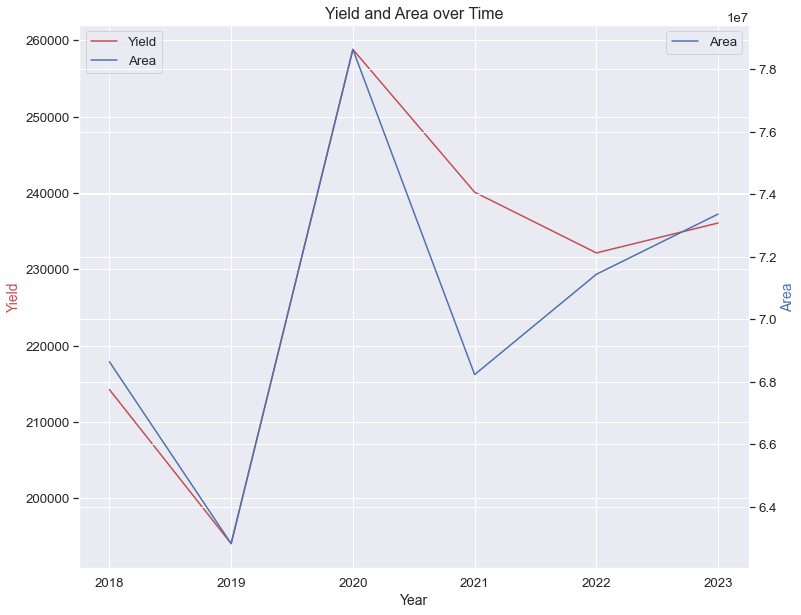

In [104]:
sns.set(font_scale=1.2)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the lines
sns.lineplot(data=df_viz, x='YEAR', y='YIELD', color="r", label="Yield", ax=ax)
ax1 = ax.twinx()
sns.lineplot(data=df_viz, x='YEAR', y='AREA', color="b", ax=ax1, label="Area")

# Set labels and titles
ax.set_ylabel('Yield', color='r', fontsize=14)
ax1.set_ylabel('Area', color='b', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Yield and Area over Time', fontsize=16)

# Set legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

# Show plot
plt.show()

In [88]:
df_state = df.groupby(by=["STATE_FIPS", "YEAR"])[["YIELD", "AREA"]].sum().reset_index()

df_state.head()

,STATE_FIPS,YEAR,YIELD,AREA
0,1,2018,4129.4,190240
1,1,2019,4002.2,218920
2,1,2020,5907.9,274740
3,1,2021,4418.6,237530
4,1,2022,3900.5,241040


In [90]:

fips_to_state = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

def fips_to_state_name(fips):
    return fips_to_state.get(fips, 'Unknown')  

df_state['STATE'] = df_state['STATE_FIPS'].apply(fips_to_state_name)

df_state.head()

,STATE_FIPS,YEAR,YIELD,AREA,STATE
0,1,2018,4129.4,190240,Alabama
1,1,2019,4002.2,218920,Alabama
2,1,2020,5907.9,274740,Alabama
3,1,2021,4418.6,237530,Alabama
4,1,2022,3900.5,241040,Alabama


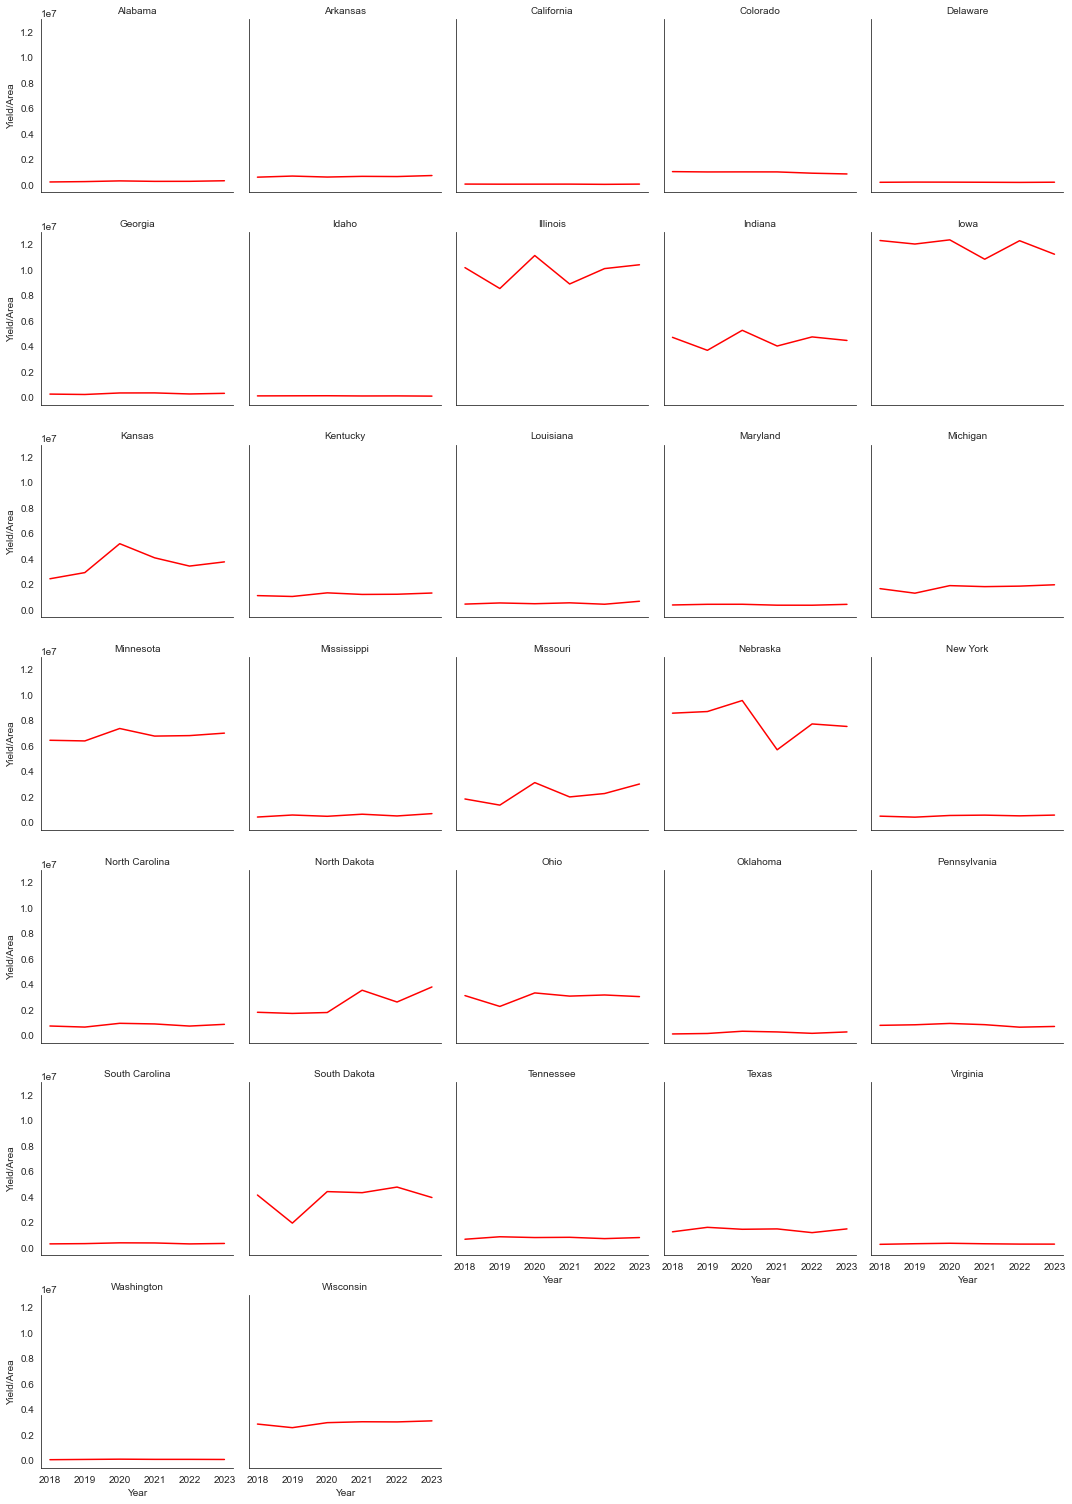

In [96]:
g = sns.FacetGrid(df_state, col="STATE", col_wrap=5, height=3)

# Map plots onto the grid
# g.map(sns.lineplot, "YEAR", "YIELD", color='blue')
g.map(sns.lineplot, "YEAR", "AREA", color='red')

# Add labels and titles
g.set_axis_labels("Year", "Yield/Area")
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

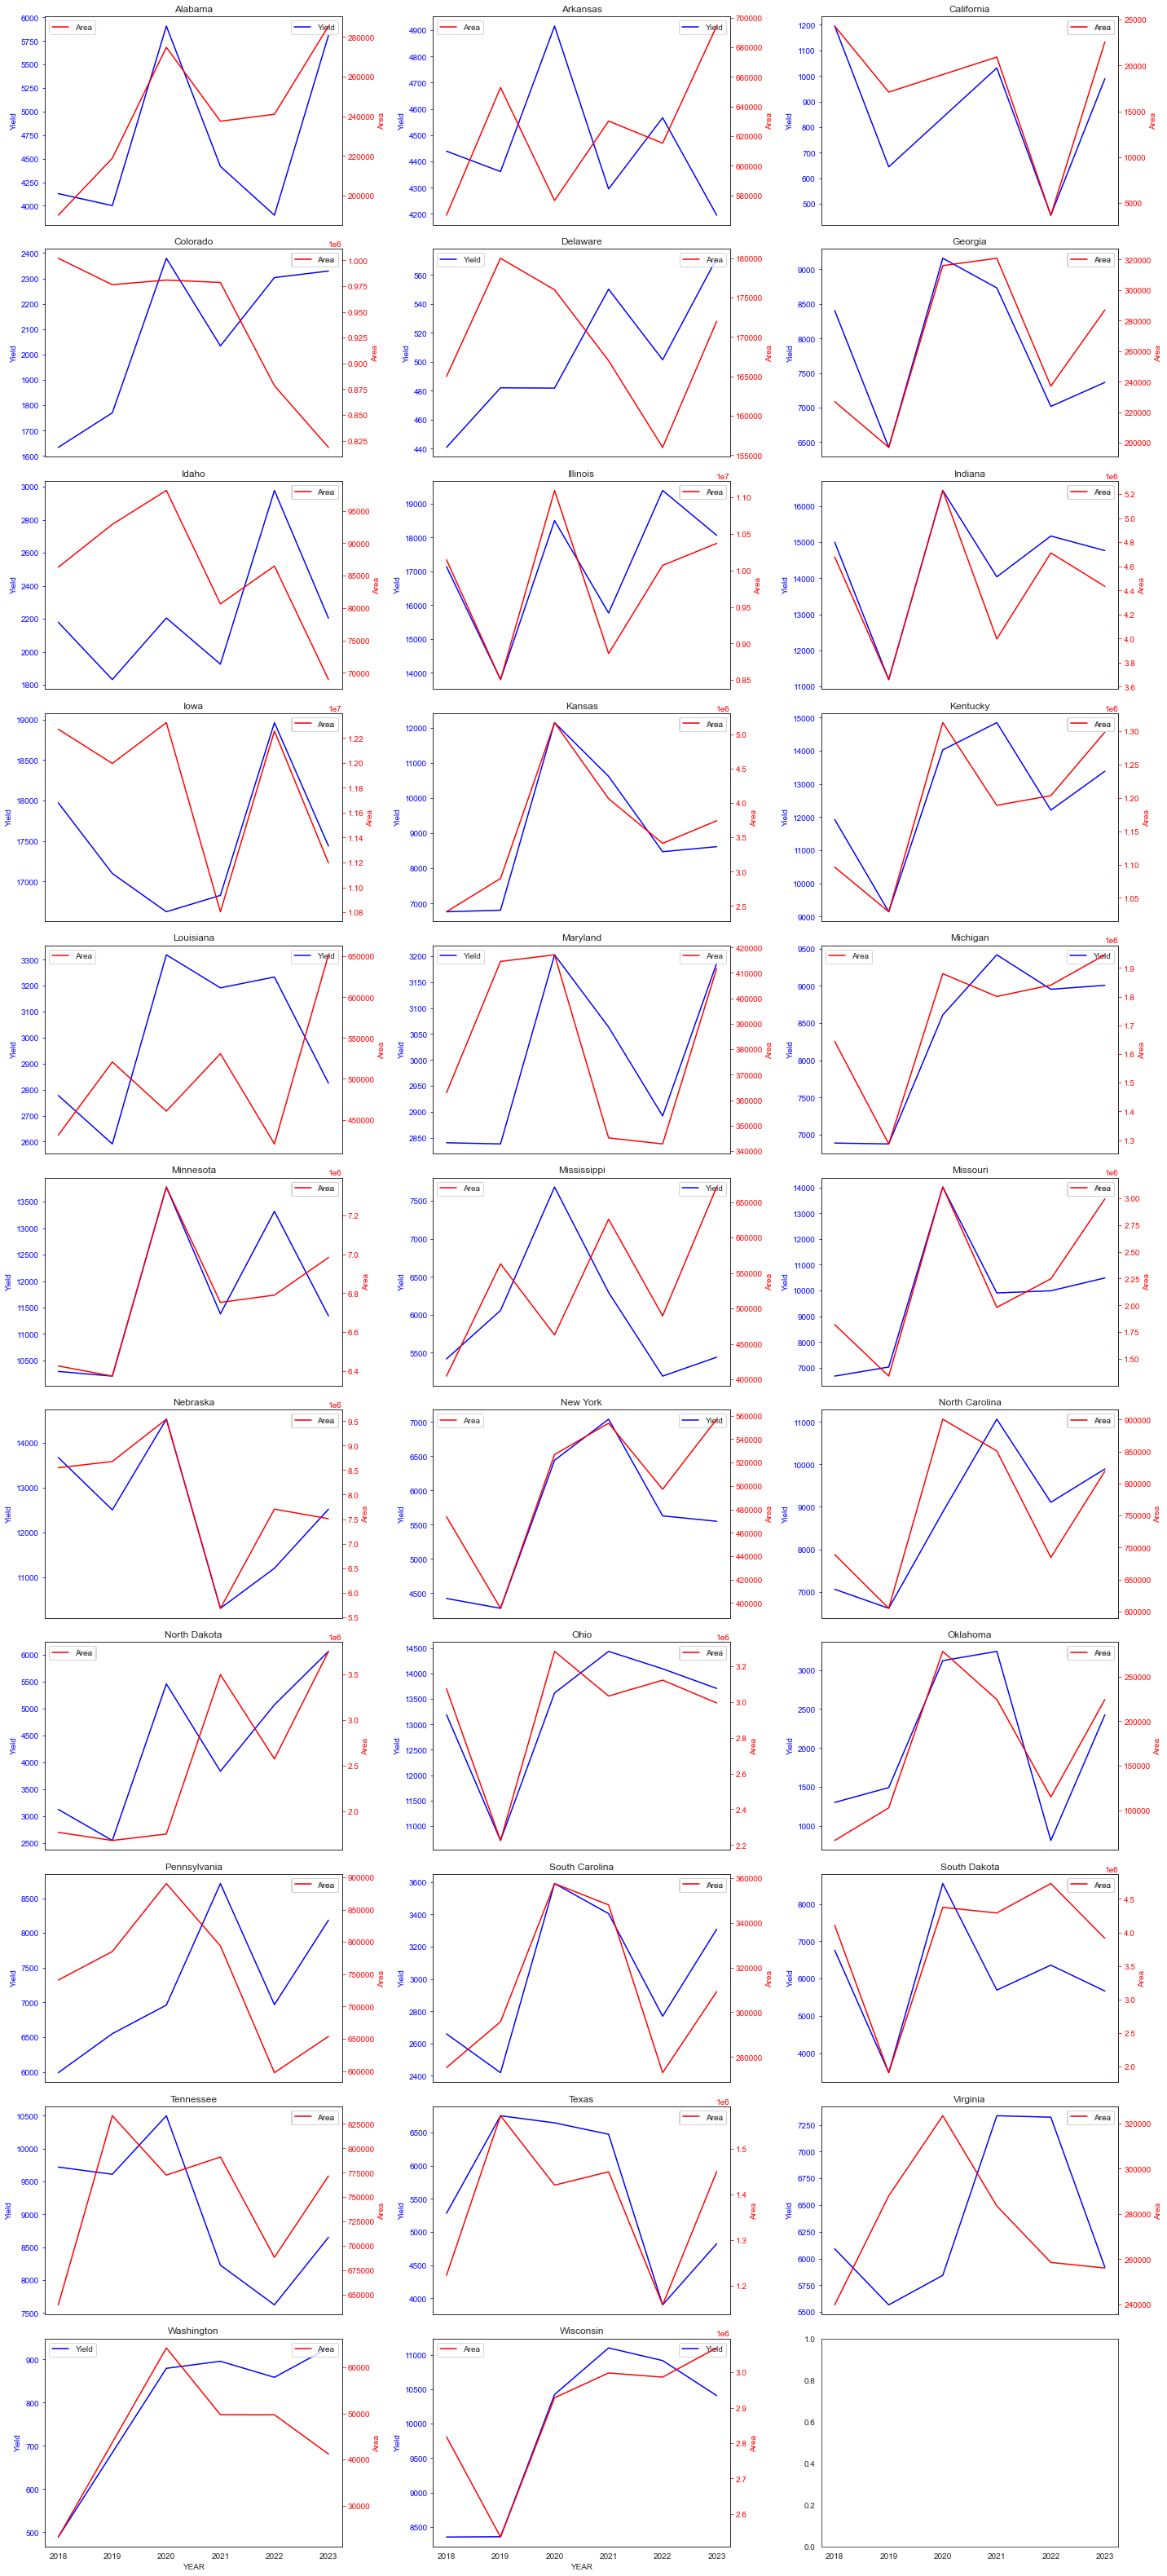

In [99]:
import math

# Determine the number of rows and columns needed for subplots
num_states = len(df_state['STATE'].unique())
num_cols = 3
num_rows = math.ceil(num_states / num_cols)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows), sharex=True)

# Iterate over each state and plot its data
for i, (state, data) in enumerate(df_state.groupby('STATE')):
    ax_row = i // num_cols
    ax_col = i % num_cols
    ax = axes[ax_row, ax_col]
    
    sns.lineplot(data=data, x='YEAR', y='YIELD', ax=ax, color='blue', label='Yield')
    ax.set_ylabel('Yield', color='blue')
    ax.tick_params(axis='y', colors='blue')
    
    # Create a secondary y-axis for area
    ax2 = ax.twinx()
    sns.lineplot(data=data, x='YEAR', y='AREA', ax=ax2, color='red', label='Area')
    ax2.set_ylabel('Area', color='red')
    ax2.tick_params(axis='y', colors='red')
    
    ax.set_title(state)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# SATELITTE IMAGING

In [39]:
ee.Authenticate()

True

In [40]:
ee.Initialize(project="ee-kaywee")

In [36]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'], \
              'MODIS/006/MYD11A2':[0,4], \
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6] \
        }  
folders = ['USDA_CROP', \
           'MODIS_TEMP', \
           'MODIS_LAND'
           ]
locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2018-1-2', '2023-1-2']
scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

county_region = ee.FeatureCollection('TIGER/2016/Counties')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
        
    # Getting images
    for i, (loc1, loc2) in enumerate(locations):

        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = county_region.filterMetadata('STATEFP', 'equals', int(loc1))
        region = ee.FeatureCollection(region).filterMetadata('COUNTYFP', 'equals', int(loc2))
        region = ee.Feature(region.first()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        if (i%250 == 0) or (i == len(locations)-1):
            print(i)



 ######################### USDA/NASS/CDL #########################
Total Dates Available:  5
Dates available:  ['2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
Band cropland will be downloaded in 5 images per county. ( 100.0 %)
0


KeyboardInterrupt: 

In [29]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = 500   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))
"""
# Getting images
for i, (loc1, loc2) in enumerate(locations):

    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
    scale  = scale
    crs = 'EPSG:4326'   # Coordinate Reference System

    # filter for a county
    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
    region = ee.Feature(region.first()) # get the coordinates and other features

    while True:
        try:
            export_image(img.clip(region), folder, im_name, scale, crs)
        except Exception:
            print(Exception)
            time.sleep(10)
            continue
        break
    if (i%500 == 0) or (i == len(locations)-1):
        print(i)
"""

Total Dates 189
There are 228 total number of images


"\n# Getting images\nfor i, (loc1, loc2) in enumerate(locations):\n\n    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n    scale  = scale\n    crs = 'EPSG:4326'   # Coordinate Reference System\n\n    # filter for a county\n    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))\n    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))\n    region = ee.Feature(region.first()) # get the coordinates and other features\n\n    while True:\n        try:\n            export_image(img.clip(region), folder, im_name, scale, crs)\n        except Exception:\n            print(Exception)\n            time.sleep(10)\n            continue\n        break\n    if (i%500 == 0) or (i == len(locations)-1):\n        print(i)\n"

In [30]:
# Check number of files

from os import listdir
from os.path import isfile, join

USDA_CROP_path = 'data/USDA_CROP/'
USDA_MOISTURE_path = 'data/USDA_MOISTURE/'
MODIS_TEMP_path = 'data/MODIS_TEMP/'
MODIS_LAND_path = 'data/MODIS_LAND/'

folder_list = [USDA_CROP_path, USDA_MOISTURE_path, MODIS_TEMP_path, MODIS_LAND_path]

USDA_CROP = [f for f in listdir(USDA_CROP_path) if isfile(join(USDA_CROP_path, f))]
USDA_MOISTURE = [f for f in listdir(USDA_MOISTURE_path) if isfile(join(USDA_MOISTURE_path, f))]
MODIS_TEMP = [f for f in listdir(MODIS_TEMP_path) if isfile(join(MODIS_TEMP_path, f))]
MODIS_LAND = [f for f in listdir(MODIS_LAND_path) if isfile(join(MODIS_LAND_path, f))]

MODIS_TEMP_fips = sorted([file[11:-4] for file in MODIS_TEMP if file[0:10] == 'MODIS_TEMP'])
USDA_CROP_fips = sorted([file[11:-4] for file in USDA_CROP if file[0:9] == 'USDA_MOISTURE'])
USDA_MOISTURE_fips = sorted([file[11:-4] for file in USDA_MOISTURE])
MODIS_LAND_fips = sorted([file[11:-4] for file in MODIS_LAND if file[0:10] == 'MODIS_LAND'])

for folder in folder_list:
    seen = set()
    uniq = [x for x in USDA_MOISTURE_fips if x not in seen and not seen.add(x)]
    print('For folder {}, there are {} files in it.'.format(folder, len(uniq)))

For folder data/USDA_CROP/, there are 0 files in it.
For folder data/USDA_MOISTURE/, there are 0 files in it.
For folder data/MODIS_TEMP/, there are 0 files in it.
For folder data/MODIS_LAND/, there are 0 files in it.
